In [1]:
cd /home

/home


In [37]:
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import shutil

from src.layers.attention import HeadAttentionMulti, scaled_dot_product_attention
from src.data.loaders import get_loader
from src.metrics.r2 import custom_r2
from src.losses import custom_rmse, rmse_for_nsp
from src.data.zero import pretraining_pipeline
from src.metrics import custom_r2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
dict_types = {1:'RRab',2:'RRc',3:'RRd',4:'Blazkho',
5:'Eclipsing Binary', 6:'EA', 
7:'Rotational Var', 8:'LPV', 
9:'delta-Scuti',10:'ACep',
11:'Misc',12:'Cep-II',13:'LMC Classical Cep'}

In [50]:
cols = ['SSS ID', 'Numerical ID', 'RA', 'Dec', 'Period', 'V_CSS', 'Npts', 'V_amp', 'Type']
md = pd.read_csv('./data/raw_data/catalina/metadata.csv', delim_whitespace=True)
md = md.iloc[:, :9]
md.columns = cols
md['Class'] = md.apply(lambda x: dict_types[x['Type']], axis=1)
md.to_csv('./data/raw_data/catalina/meta.csv', index=False)

In [62]:
df = pd.read_csv('./data/raw_data/catalina/metadata.csv')
# df = df.rename(columns={'Numerical ID': 'ID'})
# df.to_csv('./data/raw_data/catalina/metadata.csv', index=False)
df

,SSS ID,ID,RA,Dec,Period,V_CSS,Npts,V_amp,Type,Class
0,SSS_J000025.8-393651,3039001008411,0.10758,-39.61419,0.514380,14.709,230,0.260621,5,Eclipsing Binary
1,SSS_J000031.7-412854,3041001010523,0.13228,-41.48192,0.589281,19.165,145,0.829397,1,RRab
2,SSS_J000037.9-251101,3025001011039,0.15796,-25.18378,0.616695,17.560,147,0.485934,1,RRab
3,SSS_J000044.8-430758,3043001016067,0.18672,-43.13301,0.333486,15.206,212,0.371547,2,RRc
4,SSS_J000049.3-284901,3029001015115,0.20548,-28.81702,0.583042,14.819,196,0.832350,1,RRab
...,...,...,...,...,...,...,...,...,...,...
37740,SSS_J235856.4-444017,3045128019866,359.73502,-44.67139,0.331547,14.492,231,0.413086,2,RRc
37741,SSS_J235857.7-390721,3039141015122,359.74073,-39.12272,0.376851,13.140,218,0.574467,5,Eclipsing Binary
37742,SSS_J235904.9-554509,3055104006653,359.77071,-55.75254,0.244596,16.581,128,0.490079,5,Eclipsing Binary
37743,SSS_J235911.5-252341,3025163010681,359.79808,-25.39477,0.569303,17.349,105,1.157450,1,RRab


In [ ]:
# pd.read_csv('./data/raw_data/catalina/LCs/3039001008411.dat', names=['mjd', 'mag', 'err'], delim_whitespace=True)

In [3]:
# for survey in ['macho', 'atlas', 'ogle']:
#     source = './data/precords/{}/fold_0/'.format(survey)
#     target = './data/precords/maogat/fold_0/'
#     for sset in ['train', 'validation', 'test']:
#         src_files = os.listdir(os.path.join(source, sset))
#         for file in src_files:
#             if file.endswith('toml'): 
#                 continue
#             des_file = os.path.join(target, sset, '{}_{}'.format(survey, file))
#             src_file = os.path.join(source, sset, file)
#             shutil.copyfile(src_file, des_file)
            
#         des_file = os.path.join(target, sset, 'config.toml')
#         src_file = os.path.join(source, sset, 'config.toml')    
#         shutil.copyfile(src_file, des_file)

In [4]:
# train_loader = pretraining_pipeline('./data/records/atlas/fold_0/atlas_20/train/',
#                                     batch_size= 5,
#                                     window_size=200,
#                                     shuffle=True,
#                                     sampling=True,
#                                     repeat=4,
#                                     msk_frac=.5,
#                                     rnd_frac=.2,
#                                     same_frac=.2)

In [14]:
# ========== DATA ========================================
data_loader = get_loader('./data/records/macho_clean/train/',
                          batch_size=2000,
                          window_size=200,
                          probed_frac=.5,
                          random_frac=.2,
                          same_frac=0.2,
                          nsp_prob=.5,
                          sampling=True,
                          shuffle=True,
                          cache=True,
                          repeat=1,
                          normalize='random-mean',
                          aversion='base')

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
(None,)
[INFO] Loading PT task: Masking
[INFO] Cache activated


(2000, 200, 1)
(2000, 200, 1)
(2000, 200, 1)
(2000, 200, 1)


2024-04-02 22:37:04.225917: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


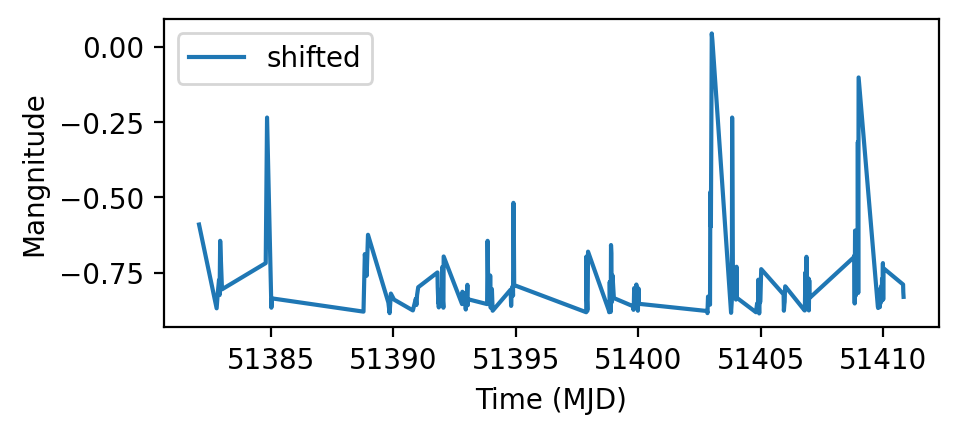

In [16]:
for x, y in data_loader.take(1):
    for a in x.keys():
        print(x[a].shape)
    plt.figure(figsize=(5, 2), dpi=200)
    plt.plot(x['times'][0], x['input'][0], label='shifted')
    
    print(y['w_error'].shape)
    plt.legend()
    plt.ylabel('Mangnitude')
    plt.xlabel('Time (MJD)')
    plt.show()

In [48]:
from src.models.astromer_1 import get_ASTROMER
from presentation.pipelines.steps.model_design import load_pt_model

In [49]:
model = get_ASTROMER(num_layers=2,
                     num_heads=4,
                     head_dim=32,
                     mixer_size=128,
                     dropout=0.,
                     pe_base=1000,
                     pe_dim=256,
                     pe_c=1,
                     window_size=200,
                     mask_format='Q',
                     use_leak=True)

# model.summary()

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only


In [50]:
# ======= MODEL ========================================


# model, conf = load_pt_model('./presentation/results/2024-03-18_07-31-24/pretraining/')

In [51]:
from src.layers.input import AddMSKToken
import tensorflow_probability as tfp

from src.losses.rmse import pearson_loss

In [52]:
for x, y in data_loader.take(1):
    output = model(x)
    loss = pearson_loss(y['target'], output, x['mask_in'])

2024-03-25 18:18:33.006827: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[INFO] Masking Query tokens only
[INFO] Masking Query tokens only


In [53]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.9953876>

tf.Tensor(
[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [0.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]], shape=(96, 200, 1), dtype=float32)
[INFO] Masking Query tokens only
[INFO] Masking Query tokens only
tf.Tensor(0.924345, shape=(), dtype=float32)


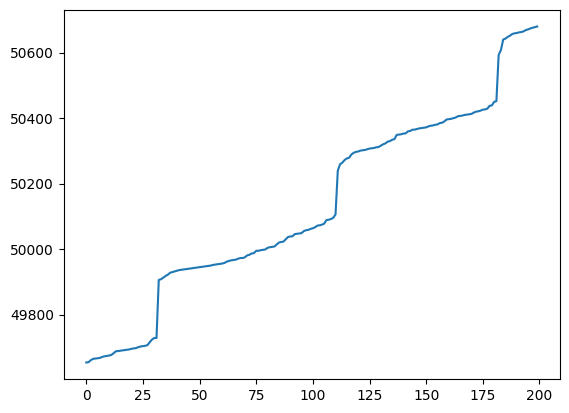

In [10]:
for x, y in data_loader.take(1):
    plt.plot(x['times'][0])
    print(x['mask_in'])
    pred = model(x)
    val_rmse = custom_rmse(y['target'], pred, mask=y['mask_out'], weights=y['w_error'])
    val_r2 = custom_r2(y['target'], pred, mask=y['mask_out'])
#     print(val_r2, val_rmse)
    print(val_rmse)

In [70]:
for x, y in data_loader.take(1):

    q = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    k = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    v = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    
    output, weights, mask = scaled_dot_product_attention(q, k, v, 
                                                         mask=x['att_mask'], 
                                                         return_mask=True)

In [71]:
mask.shape, weights.shape

(TensorShape([2000, 1, 200, 200]), TensorShape([2000, 4, 200, 200]))

tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)


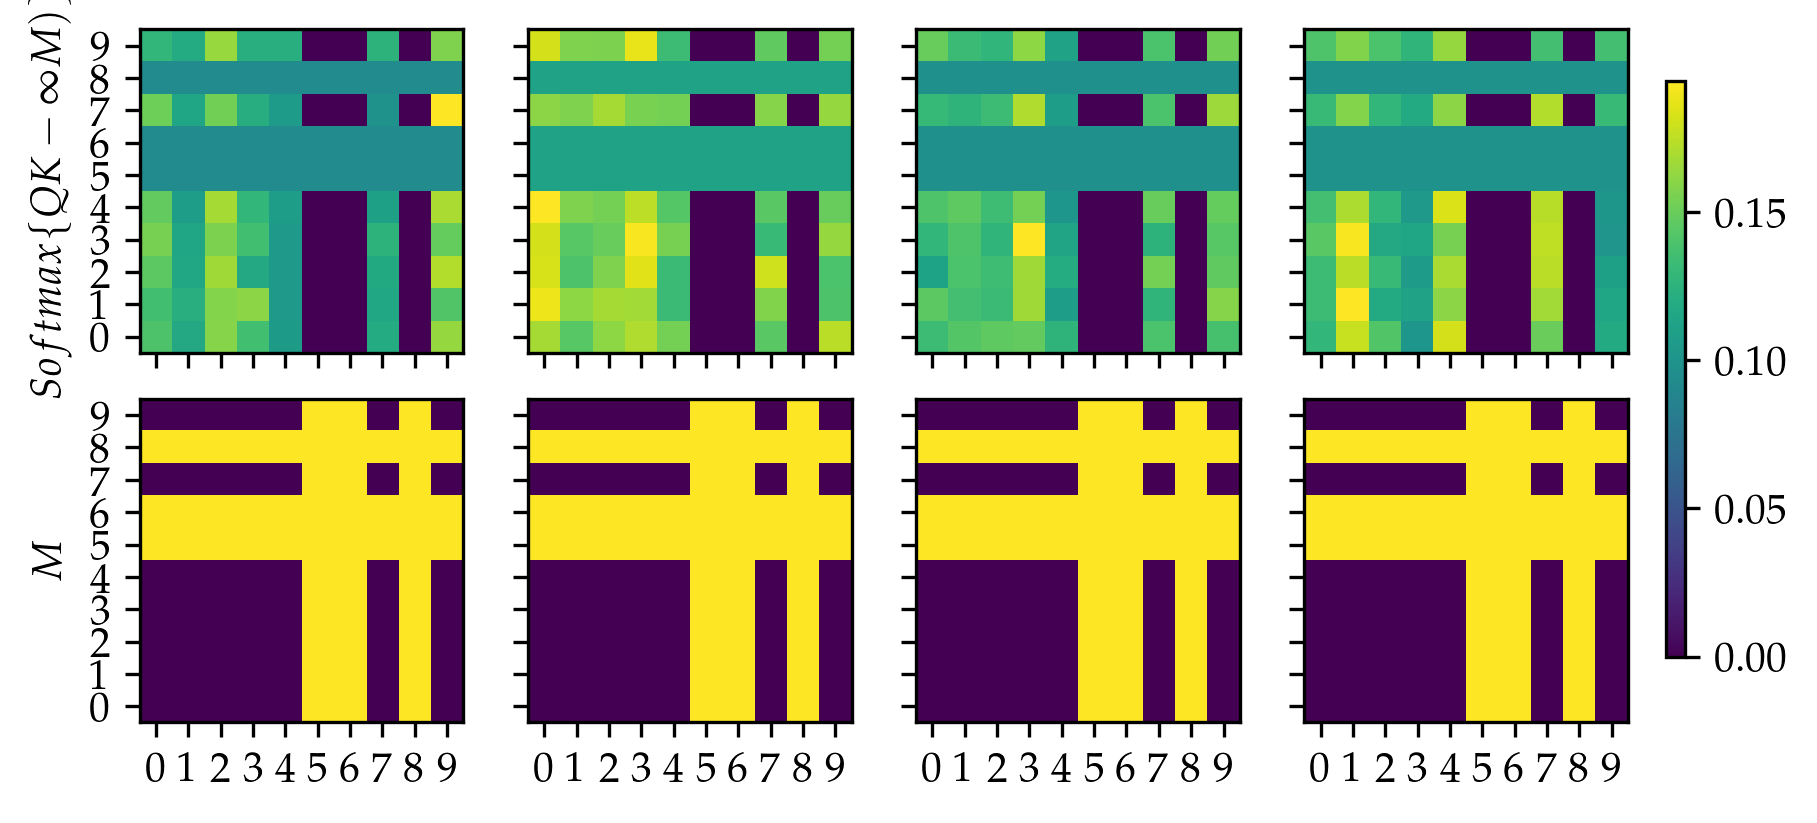

In [93]:
fig, axes = plt.subplots(2, 4, dpi=300, 
                         gridspec_kw={'hspace': -0.5, 'wspace': 0.2}, 
                         sharex=True, sharey=True)
for i in range(4):
    print(x['att_mask'][0, :, 0])
    prod = weights*(1.-mask)
    im = axes[0][i].imshow(weights[0, i], extent=(0, 10, 0, 10))
    axes[0][i].set_xticks(range(10))
    axes[0][i].set_yticks(range(10))


    axes[1][i].imshow(mask[0, 0], extent=(0, 10, 0, 10))
    
    for k in range(2):
        axes[k][i].set_xticks(np.arange(0.5, 10.5))
        axes[k][i].set_yticks(np.arange(0.5, 10.5))
        axes[k][i].set_xticklabels(np.arange(0, 10))
        axes[k][i].set_yticklabels(np.arange(0, 10))
    
    axes[0][0].set_ylabel(r'$Softmax{\{QK-\infty M)\}}$')
    axes[1][0].set_ylabel(r'$M$')
    
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.colorbar(im, cax=cbar_ax)

In [11]:
model = get_ASTROMER(window_size=10)
for x, y in data.take(1):
    y_pred = model(x)
    

In [12]:
custom_r2(y['magnitudes'], y_pred, y['probed_mask'])

<tf.Tensor: shape=(), dtype=float32, numpy=-52.31381>